# Project: Predicting future NBA Most Valuable Player (MVP)

# Part 3: Predict the MVP Vote Share of players based on their stats

## Define the predictors we want to use

In [1]:
import pandas as pd

In [2]:
stats = pd.read_csv('stats_clean.csv')

In [3]:
stats.columns

Index(['Unnamed: 0', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Year', 'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%',
       'GB', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [4]:
del stats['Unnamed: 0']

Let's define our predictors (i.e. the columns we want to use to predict the MVP for a given season). We'll remove the *object* columns (`Player`, `Pos`, `Tm`& `Team`) as well as the variable directly related to `Share` (`Pts Won`, `Pts Max`, `Share`).

In [5]:
predictors = ['Age', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Year', 'W', 'L', 'W/L%',
       'GB', 'PS/G', 'PA/G', 'SRS']

## Define train/test datasets for a single year (2023) & run our fist prediction

Next, we need to define our **train** and **test** dataframes which will respectively be used to train the ML model and then test it. We'll use the stats up to but not including **2023** to train our model and then test on **2023**. Obviously, we don't want to include the test data into the model training! 

If we had 2024 stat data, we could do a *real life* scenario to predict the 2024 MVP but as of today the season has only just started - maybe something to come back to in a few months! Anyway, we'll be able to assess how well our model as done because we actually know the outcome of the 2023 MVP vote. 

In [6]:
train = stats[stats["Year"] < 2023]

In [7]:
test = stats[stats["Year"] == 2023]

We're going to use a fairly simple model to start with: Ridge Regression (form of linear regression to avoid over-fitting by shrinking the *alpha* coefficient)

In [8]:
# Import the model
from sklearn.linear_model import Ridge

# Initialise the model (we'll play around with alpha to see the impact)
reg = Ridge(alpha=0.1)

In [9]:
# Fit our model: using the *train* df
reg.fit(train[predictors], train["Share"])

Ridge(alpha=0.1)

In [10]:
# Run predictions for 2023 using the *test* df
predictions = reg.predict(test[predictors])

## Define a relevant error metric and take a look at model performance

We've now predicted the **MVP vote share** for all players in 2023! The output of the model prediction is a NumPy array, we'll convert it to a df so it's easier to work with (we'll set the index to match the test dataframe for consistency). And we'll combine the **test** and **predictions** into one df to see how the model has performed. *Note: the **test** df contains all the columns (incl. `Share` - but the predictors that we used did not!)*

In [11]:
predictions = pd.DataFrame(predictions, columns=["Predictions"], index=test.index)

In [12]:
# Only interested in the players and there actual Share of votes, not all the stats
combination = pd.concat([test[["Player", "Share"]], predictions], axis=1) 

In [13]:
# How did the model perform? Sort by actual Share
combination.sort_values("Share",ascending=False).head(10)

,Player,Share,Predictions
14849,Joel Embiid,0.915,0.201829
736,Nikola Jokić,0.674,0.173426
214,Giannis Antetokounmpo,0.606,0.225130
2898,Jayson Tatum,0.280,0.137573
1322,Shai Gilgeous-Alexander,0.046,0.148548
13682,Donovan Mitchell,0.030,0.086236
4274,Domantas Sabonis,0.027,0.092882
306,Luka Dončić,0.010,0.195437
6686,Stephen Curry,0.005,0.106767
10869,Jimmy Butler,0.003,0.109476


In [14]:
# How did the model perform? Sort by Predictions
combination.sort_values("Predictions",ascending=False).head(10)

,Player,Share,Predictions
214,Giannis Antetokounmpo,0.606,0.225130
14849,Joel Embiid,0.915,0.201829
306,Luka Dončić,0.010,0.195437
736,Nikola Jokić,0.674,0.173426
1322,Shai Gilgeous-Alexander,0.046,0.148548
11528,Kevin Durant,0.000,0.141083
8563,Anthony Davis,0.000,0.140287
2898,Jayson Tatum,0.280,0.137573
8083,Damian Lillard,0.000,0.136843
8570,LeBron James,0.000,0.133830


The aim of this analysis is to predict who's going to be the next MVP (and the top 5, if we want to extend the scope) - so we are interest in the **rank of predictions** not the absolute values predicted!

A quick scan through the two tables above tells us that our model didn't predict the MVP correctly but did manage to get 6/10 in the Top 10 correctly. Whether the model performed better or worse than we've just observed, we need to define an error metric that will tell us **how well** the model has performe (this metric needs to be relevant in the context of what we're looking at!). 

In this case we're not trying to accurately predict the vote share for all players (vast majority don't get any votes anyway) - instead we can decide that for this analysis success is: **predict the Top 5**. Our error metric should therefore give us an understanding of how well our model has done that. 

We'll start by defining a function that add the ranks:

In [15]:
def add_ranks(combination):
    # Actual Share rank
    combination = combination.sort_values(["Share"], ascending=False)
    combination["Rank"] = list(range(1,combination.shape[0]+1))
    
    # Predicted rank
    combination = combination.sort_values(["Predictions"], ascending=False)
    combination["Predicted_Rank"] = list(range(1,combination.shape[0]+1)) 
    
    # Difference
    combination["Difference"] = combination.Rank - combination.Predicted_Rank
    
    return combination

We've create a function that will return our error metric - closer to 1 the best our model has performed. The functions assess how well the model has predicted the Top "X" (we'll use 5 as our example). The function assess each predicted rank compared to the actual MVP rank, and averages it over the Top X.

We've arbitrarly quantified success:
* Exact position predicted = 1
* Prediction in the Top X but not at the correct position (formula, see below)
* Prediction not in the Top X (other formula, see below)

In [16]:
# Create a function to define and calulate our error metric
def find_avg_precision_top_X(combination,topX=5):
    
    combination = add_ranks(combination)
    
    # Initialise our metric
    metric = []
    
    for i in range(topX):
        if combination.Rank.iloc[i] <= topX:
            if combination.Rank.iloc[i] == combination.Predicted_Rank.iloc[i]:
                m = 1                
            else:
                m = 0.7 + 0.3 * 1/(abs(combination.Rank.iloc[i] - combination.Predicted_Rank.iloc[i])+1)
        else:
            m = 0.3 + 0.7 * 1/(abs(combination.Rank.iloc[i] - combination.Predicted_Rank.iloc[i])+1)
            
        metric.append(m)
    
    # Return metric    
    return sum(metric)/len(metric)

In [17]:
find_avg_precision_top_X(combination,topX=5)

0.7733333333333332

We've now defined an error metric and assessed how the model performed for predicting the 2023 vote share. Only testing the model on a single year can be missleading (2023 could have been a rogue year for any reason) and doesn't allow for any comparision (a singular error metric on its own doesn't tell us anything - especially when arbitrarily defined).

So instead we're going to create a **back-testing function** to which we'll pass a stat `dataframe`, a `model`, the `TopX` parameter for our error metric and the list of `predictors` to use. The function will iteratively run multiple predictions (i.e., predict Share for year **n** by training the model on year **1 to n-1**). 

The outputs are: the **mean avgerage precision** (average of all average precision metrics), the list of **average precisions** and a dataframe of **all predictions** (for each iteration).

In [18]:
def backtest(stats=stats, predictors=predictors, model=reg, topX=5, startYear=1996):
    
    # Set years
    years = list(range(min(stats.Year),max(stats.Year)+1))
    
    # Check the start year is above the minimum of [min(years)+5]
    if startYear < min(stats.Year)+5:
        raise ValueError(f"""
        The start year needs to be above or equal to {min(stats.Year)+5} in order to train the model 
        with at least have 5 years worth of data for the first iteration.
        """)

    # Initialise the "avergae precision" and "all predictions" lists
    aps = []
    all_predictions = []
    
    # Train and test the model iteratively (back-testing)
    for year in years[years.index(startYear):]:
                
        train = stats[stats["Year"] < year]
        test = stats[stats["Year"] == year]
        model.fit(train[predictors],train["Share"])
        predictions = model.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns=["Predictions"], index=test.index)
        combination = pd.concat([test[["Player", "Share"]], predictions], axis=1)
        combination = add_ranks(combination)
        combination["Year"] = year
        all_predictions.append(combination)
        aps.append(find_avg_precision_top_X(combination,topX))
    
    # Return the "mean avgerage precision" and a dataframe containing "all predictions"
    return sum(aps)/len(aps), aps, pd.concat(all_predictions)

In [19]:
mean_avg_precision, avg_precisions, all_predictions = backtest(
    stats, predictors, model=reg, topX=5, startYear=1996)

Now that we have multiple performance indicators (thanks to the iterative back-testing we've just run), let's take a look at our error metric: 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def track_error_metric(stats=stats, predictors=predictors, model=reg, topX=5, startYear=1996):
    
    # Call on back-testing function & set years
    mean_avg_precision, avg_precisions, all_predictions = backtest(
        stats, predictors, model, topX, startYear)
    
    years = list(range(min(stats.Year),max(stats.Year)+1))

    # initialise the figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot a bar chart in 1st tile
    axes[0].bar(range(len(avg_precisions)), avg_precisions, color='skyblue')
    axes[0].axhline(mean_avg_precision, color='red', linestyle='dashed', linewidth=1, label='Mean')
    axes[0].text(len(avg_precisions), mean_avg_precision, f'Mean: {mean_avg_precision:.3f}', 
             color='red', verticalalignment='bottom', horizontalalignment='right')
    axes[0].set_xticks(range(len(years[years.index(startYear):])))
    axes[0].set_xticklabels(years[years.index(startYear):], rotation=90)
    axes[0].set_xlabel('Predictions')
    axes[0].set_ylabel('Error Metric')
    axes[0].set_yticks(np.arange(0, 1.1, 0.1))


    # Plot a boxplot in 2nd tile
    axes[1].boxplot(avg_precisions)
    axes[1].set_xticklabels([''])
    axes[1].set_xlabel('Spread')
    axes[1].set_yticks(axes[0].get_yticks())
    axes[1].set_yticks(np.arange(0, 1.1, 0.1))
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display plot
    plt.tight_layout()
    plt.show()
    plt.close()

The plot below tells us how the model (`Ridge` in this case) has performed based on our `Error metric` through th back-testing. Each year on the bar chart represent the model's prediction for that year, using the stats data available from previous years (from 1991 in this case). 

This gives us an idea of the consitency of predictions and highlights particularly bad years for the model - giving us a starting point for modelling improvement. It'll also allow us to quickly assess if different models perform better or worse.

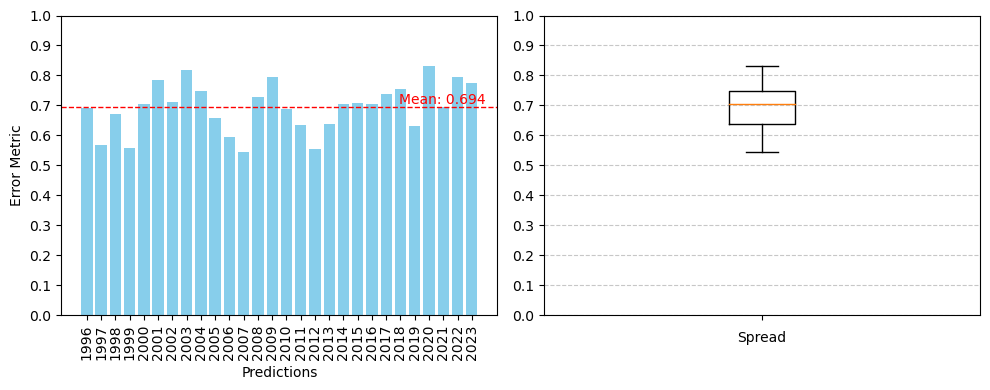

In [21]:
track_error_metric(stats=stats, predictors=predictors, model=reg, topX=5, startYear=1996)

## Diagnosis of model performance

We can look at `all_predictions` to see what the model hasn't predicted so well. 

Looking at the largest "under predictions" of the model gives us a few data point to go look at if we want to give in deeper (i.e., we might want to go look at the team results, the position and/or the stats of these player to see what made the model "under value" their season). We might see trends emerge (e.g., a certain position tends to be "under valued". We can then tweak the model if need be.

*Note: in this case we're only interested in looking at the Top 5 or Top 10 as we have been throughout this project. We have no interest in understanding mis-predicted ranks at the bottom & only a handfull of players actually get MVP votes anyway!*

In [22]:
all_predictions[all_predictions["Rank"] <= 5].sort_values("Difference").head(20)

,Player,Share,Predictions,Rank,Predicted_Rank,Difference,Year
1441,Jason Kidd,0.712,0.028210,2,52,-50,2002
9009,Glen Rice,0.117,0.033110,5,53,-48,1997
5674,Steve Nash,0.839,0.034100,1,45,-44,2005
9277,Peja Stojaković,0.228,0.036270,4,38,-34,2004
5692,Steve Nash,0.739,0.054129,1,34,-33,2006
13800,Joakim Noah,0.258,0.046968,4,37,-33,2014
4010,Chauncey Billups,0.344,0.052696,5,35,-30,2006
1606,Chris Paul,0.138,0.072293,5,33,-28,2021
5707,Steve Nash,0.785,0.074421,2,21,-19,2007
5151,Tim Hardaway,0.207,0.059984,4,20,-16,1997


In association with the table above, we can take a look at model's **coefficients** to see which predictors are most influencial on `Share`. We can then look at if any of the players in the df above have reletively low stats in these influencial predictors but excel in others (potentially justifing their high actual rank).

In [23]:
pd.concat([pd.Series(reg.coef_), pd.Series(predictors)], axis=1).sort_values(0, ascending=False).head(10)

,0,1
13,0.104300,eFG%
18,0.033422,DRB
29,0.028124,W/L%
17,0.020394,ORB
10,0.017390,2P
21,0.012038,STL
22,0.010571,BLK
15,0.010230,FTA
12,0.008651,2P%
20,0.006953,AST


## Improving our predictions

### 1. Add more predictors

We can add some numerical predictors (which a linear model can make use of):

In [24]:
# Calculate the ratio of key stats
stats_ratios = stats[['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV','Year']] \
    .groupby('Year', group_keys=False) \
    .apply(lambda x: x/x.mean())

# Add these new stats to the df 
stats[['PTS_R', 'ORB_R', 'DRB_R', 'TRB_R', 'AST_R', 'STL_R', 'BLK_R', 'TOV_R']] = \
    stats_ratios[['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']]

# include them into the predictors
predictors += ['PTS_R', 'ORB_R', 'DRB_R', 'TRB_R', 'AST_R', 'STL_R', 'BLK_R', 'TOV_R']

In [25]:
#stats_ratios.head(5)
#stats.head(5)

In [26]:
mean_avg_precision, avg_precisions, all_predictions = backtest(
    stats, predictors, model=reg, topX=5, startYear=1996)

In [27]:
#all_predictions[all_predictions["Rank"] <= 5].sort_values("Difference").head(20)

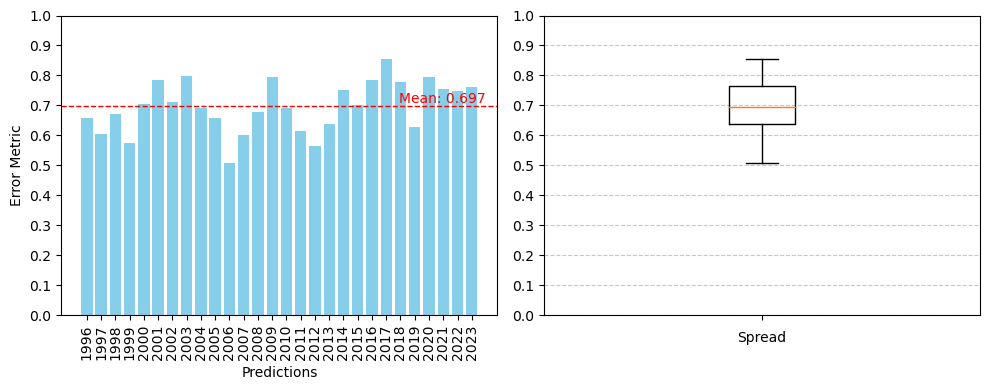

In [28]:
track_error_metric(stats=stats, predictors=predictors, model=reg, topX=5, startYear=1996)

In this case, adding predictors hasn't really added anything. The mean average precision is virtually the same and the consistency of the model was also pretty much uneffected. 

We can also add some categorical predictors - but a linear regression model won't be able to make use of them effectively (probably would be detrimental to the prediction because by nature a linear model looks at the linear correlations). 

We'll add 2 new predictors: `nPos` (from players' positions) and `nTm` (from players' teams). Even though these are categorical, we'll convert them to a numerical code so that most models can use them. We'll add these as predictors in the section below.

In [29]:
stats["nPos"] = stats.Pos.astype('category').cat.codes
stats["nTm"] = stats.Tm.astype('category').cat.codes

### 2. Using a different model

We're now going to try a different model: **Random Forest model**. 

Briefly, this type of models splits and groups the data into different branches. Will run predictions for each branches and then average them. (Very high level! Need to go learn about the different ML models!)

The great thing is we can use our backtest function to run the prediction using different models and predicors!

*RandomForestRegressor Note:

- `n_estimator` is the number of branches (higher is more accurate but longer!)
- `random_state = 1` means that we want the results to be the same if we ran the same test
- `min_samples_split` each branch split needs to use a minimum of variable/columns to make a prediction (higher = quicker, less accurate but also less prone to over-fitting)
- can take a fair bit of time! (we'll experiment with different rf settings & we can also run our back-testing function from a more recent year)

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_split=5)

In [31]:
predictors_2 = predictors + ["nPos", "nTm"]

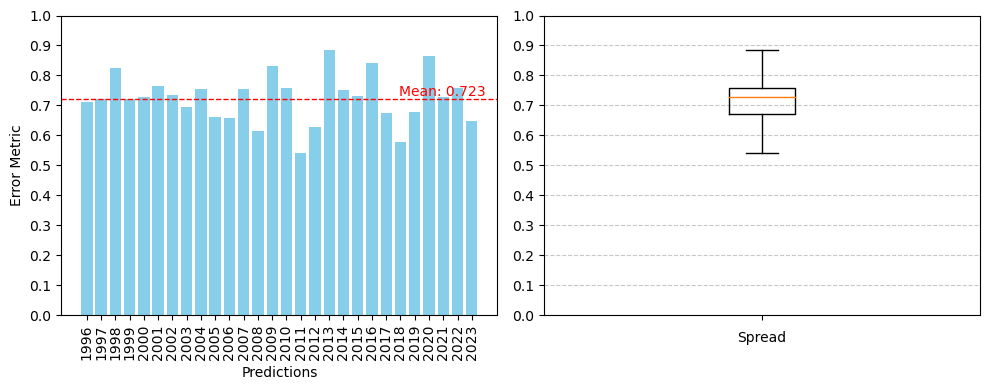

In [32]:
error_metric_rf = track_error_metric(stats=stats, predictors=predictors_2, model=rf, topX=5, startYear=1996)

For consitency, we'll compare to the **Ridge model** (making sure we use the same start year if we changed it for the random forest model)

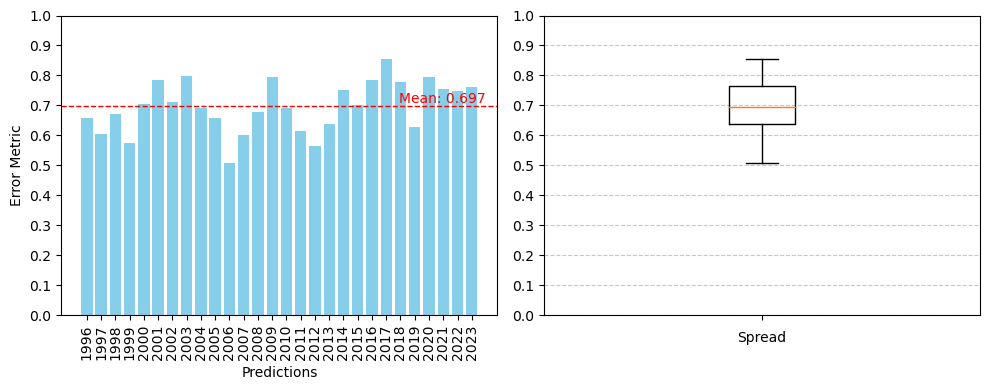

In [33]:
error_metric_ridge = track_error_metric(stats=stats, predictors=predictors, model=reg, topX=5, startYear=1996)

The Random Forest model has performed better at predicting the Top 5 (on the basis of our error metric) - as expected. However it hasn't solved the irregularity/spread of predictions, we'd need to look at some of next steps ideas below to address this issue!

## Some next steps ideas

* Play around with `alpha` for Ridge model
* Design a unit test to find the optimal parameters for our Random Forest model (i.e., maximise our mean avgerage precision metric)
* Experiment with other ML models
* Consider other predictors, maybe different grouping too
* Could experiment with a slightly different aim - and therefore error metric.